In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.cuda as cuda
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from torch.autograd import Variable
from torch.utils.data import TensorDataset

In [2]:
features = np.load('dnnx_exp2.npy',allow_pickle=True)
labels = np.load('y_exp2.npy',allow_pickle=True)

In [3]:
indices = np.where(labels!='QSO')
sg_feat = features[indices]
sg_label = labels[indices]

In [4]:
print(sg_feat.shape)
print(sg_label.shape)

(99996, 24)
(99996,)


In [5]:
scaler = StandardScaler()
sg_feat = scaler.fit_transform(sg_feat)

In [6]:
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(sg_label)
sg_label = integer_labels.reshape(-1)

In [7]:
sg_feat = torch.from_numpy(sg_feat)
sg_label = torch.from_numpy(sg_label)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sg_feat,sg_label, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111111, random_state=42)

In [9]:
train_set = TensorDataset(X_train,y_train)
val_set = TensorDataset(X_val,y_val)
batch_size = 2048
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=1)
val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=1)

In [10]:
 class ANNClassifier(nn.Module):
        def __init__(self,input_size,h1,h2,h3,h4,h5,output_size):
            super(ANNClassifier,self).__init__()
            self.fc1 = nn.Linear(input_size,h1)
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.25)
            self.fc2 = nn.Linear(h1,h2)
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(0.25)
            self.fc3 = nn.Linear(h2,h3)
            self.relu3 = nn.ReLU()
            self.dropout3 = nn.Dropout(0.25)
            self.fc4 = nn.Linear(h3,h4)
            self.relu4 = nn.ReLU()
            self.dropout4 = nn.Dropout(0.25)
            self.fc5 = nn.Linear(h4,h5)
            self.relu5 = nn.ReLU()
            self.dropout5 = nn.Dropout(0.25)
            self.fc6 = nn.Linear(h5,output_size)
            
        def forward(self,x):
            x = self.fc1(x)
            x = self.relu1(x)
            x = self.dropout1(x)
            x = self.fc2(x)
            x = self.relu2(x)
            x = self.dropout2(x)
            x = self.fc3(x)
            x = self.relu3(x)
            x = self.dropout3(x)
            x = self.fc4(x)
            x = self.relu4(x)
            x = self.dropout4(x)
            x = self.fc5(x)
            x = self.relu5(x)
            x = self.dropout5(x)
            x = self.fc6(x)
            return x      

In [11]:
net = ANNClassifier(24,1024,512,256,128,64,2)
net = net.cuda()
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(),lr=lr)

In [12]:
num_epochs = 1000
train_loss=[]
valid_loss=[]
train_accuracy=[]
valid_accuracy=[]

In [13]:
for epoch in range(num_epochs):
    iter_loss = 0.0
    correct = 0
    iterations = 0
    total = 0
    net.train()
    
    for i, (features, labels) in enumerate(train_loader):
        features = Variable(features.float().cuda())
        labels = Variable(labels.long().cuda())
        
        optimizer.zero_grad()
        outputs = net(features)
        loss = F.nll_loss(F.log_softmax(outputs, dim=1), labels)
        
        iter_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        iterations += 1
    
    train_loss.append(iter_loss / iterations)
    train_accuracy.append((100 * correct) / total)
    
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    net.eval()
    
    for i, (feat, lab) in enumerate(val_loader):
        feat = Variable(feat.float().cuda())
        lab = Variable(lab.long().cuda())
        
        out = net(feat)
        loss = F.nll_loss(F.log_softmax(out, dim=1), lab)
        
        val_loss += loss.item()
        _, predicted_val = torch.max(out, 1)
        correct_val += (predicted_val == lab).sum().item()
        total_val += lab.size(0)
    
    valid_loss.append(val_loss / len(val_loader))
    valid_accuracy.append((100 * correct_val) / total_val)
    
    print('epoch %d/%d, trloss: %.4f, tracc: %.4f, valloss: %.4f, valacc: %.4f' % (epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))

epoch 1/1000, trloss: 0.6964, tracc: 49.9712, valloss: 0.6939, valacc: 50.6600
epoch 2/1000, trloss: 0.6941, tracc: 50.0563, valloss: 0.6921, valacc: 50.6600
epoch 3/1000, trloss: 0.6925, tracc: 50.2438, valloss: 0.6906, valacc: 50.7500
epoch 4/1000, trloss: 0.6911, tracc: 50.7088, valloss: 0.6891, valacc: 51.1700
epoch 5/1000, trloss: 0.6895, tracc: 53.1839, valloss: 0.6875, valacc: 51.8100
epoch 6/1000, trloss: 0.6881, tracc: 57.7554, valloss: 0.6857, valacc: 54.9200
epoch 7/1000, trloss: 0.6862, tracc: 63.4894, valloss: 0.6834, valacc: 75.6000
epoch 8/1000, trloss: 0.6840, tracc: 67.9909, valloss: 0.6806, valacc: 80.2400
epoch 9/1000, trloss: 0.6811, tracc: 71.0273, valloss: 0.6768, valacc: 80.3000
epoch 10/1000, trloss: 0.6773, tracc: 73.0374, valloss: 0.6717, valacc: 79.8300
epoch 11/1000, trloss: 0.6718, tracc: 74.8737, valloss: 0.6647, valacc: 79.2500
epoch 12/1000, trloss: 0.6639, tracc: 76.2463, valloss: 0.6546, valacc: 79.0600
epoch 13/1000, trloss: 0.6532, tracc: 77.2651, va

In [14]:
torch.save(net.state_dict(), 'annclassifiersg2.pth')

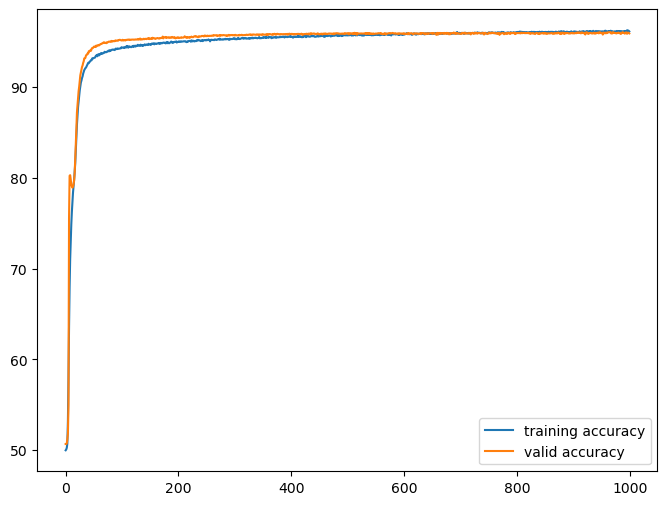

In [15]:
f = plt.figure(figsize=(8,6))
plt.plot(train_accuracy,label='training accuracy')
plt.plot(valid_accuracy,label='valid accuracy')
plt.legend()
plt.show()

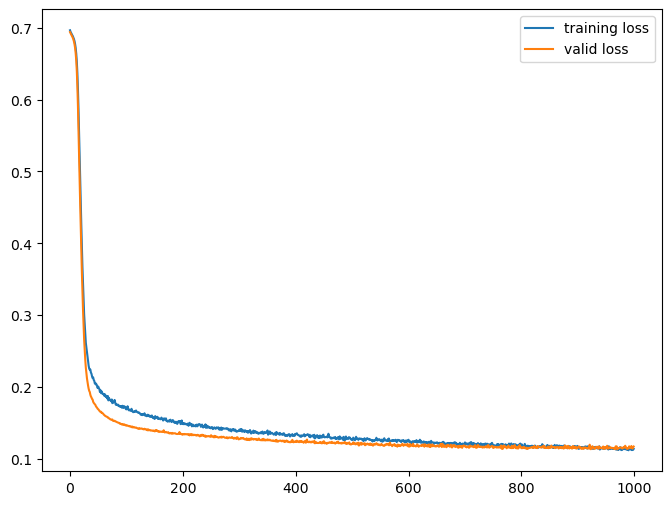

In [16]:
f = plt.figure(figsize=(8,6))
plt.plot(train_loss,label='training loss')
plt.plot(valid_loss,label='valid loss')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
net.eval()
X_test = X_test.float()
X_test = X_test.cuda()
y_pred = net(X_test)
y_pred = F.softmax(y_pred,dim=1)
y_pred = y_pred.detach().cpu().numpy()
y_pred = np.argmax(y_pred,axis=1)
y_test = y_test.detach().cpu().numpy()
acc = accuracy_score(y_test, y_pred)
pr = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test,y_pred,average='macro')
cm = confusion_matrix(y_pred,y_test)

print('accuracy :',acc)
print('precision :',pr)
print('recall :',rec)
print('f1 score :',f1)

accuracy : 0.9614
precision : 0.9619290767055079
recall : 0.9614205844456416
f1 score : 0.9613901158696625


In [18]:
report = classification_report(y_pred,y_test)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5166
           1       0.94      0.98      0.96      4834

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [19]:
cm

array([[4887,  279],
       [ 107, 4727]], dtype=int64)